In [14]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import os


In [15]:
from google.colab import drive
drive.mount('/content/drive')

train_dir = "/content/drive/MyDrive/Brain-Tumor/Training"
test_dir = "/content/drive/MyDrive/Brain-Tumor/Testing"

# Verify paths exist
if os.path.exists(train_dir):
    print(f"✓ Training directory found: {train_dir}")
    print(f"  Classes found: {os.listdir(train_dir)}")
else:
    print(f"✗ Training directory NOT found: {train_dir}")
    print("  Please update the path to match your Google Drive structure")

if os.path.exists(test_dir):
    print(f"✓ Testing directory found: {test_dir}")
    print(f"  Classes found: {os.listdir(test_dir)}")
else:
    print(f"✗ Testing directory NOT found: {test_dir}")
    print("  Please update the path to match your Google Drive structure")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Training directory found: /content/drive/MyDrive/Brain-Tumor/Training
  Classes found: ['no_tumor', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor']
✓ Testing directory found: /content/drive/MyDrive/Brain-Tumor/Testing
  Classes found: ['meningioma_tumor', 'no_tumor', 'pituitary_tumor', 'glioma_tumor']


DATA QUALITY DIAGNOSTIC

Class Distribution:
----------------------------------------------------------------------
Class                       Training    Testing      Total
----------------------------------------------------------------------
glioma_tumor                     826        100        926
meningioma_tumor                 822        115        937
no_tumor                         395        105        500
pituitary_tumor                  827         74        901
----------------------------------------------------------------------
TOTAL                           2870        394       3264

Imbalance Ratio: 2.09:1
✓ Class distribution is acceptable

SAMPLE IMAGES FROM EACH CLASS


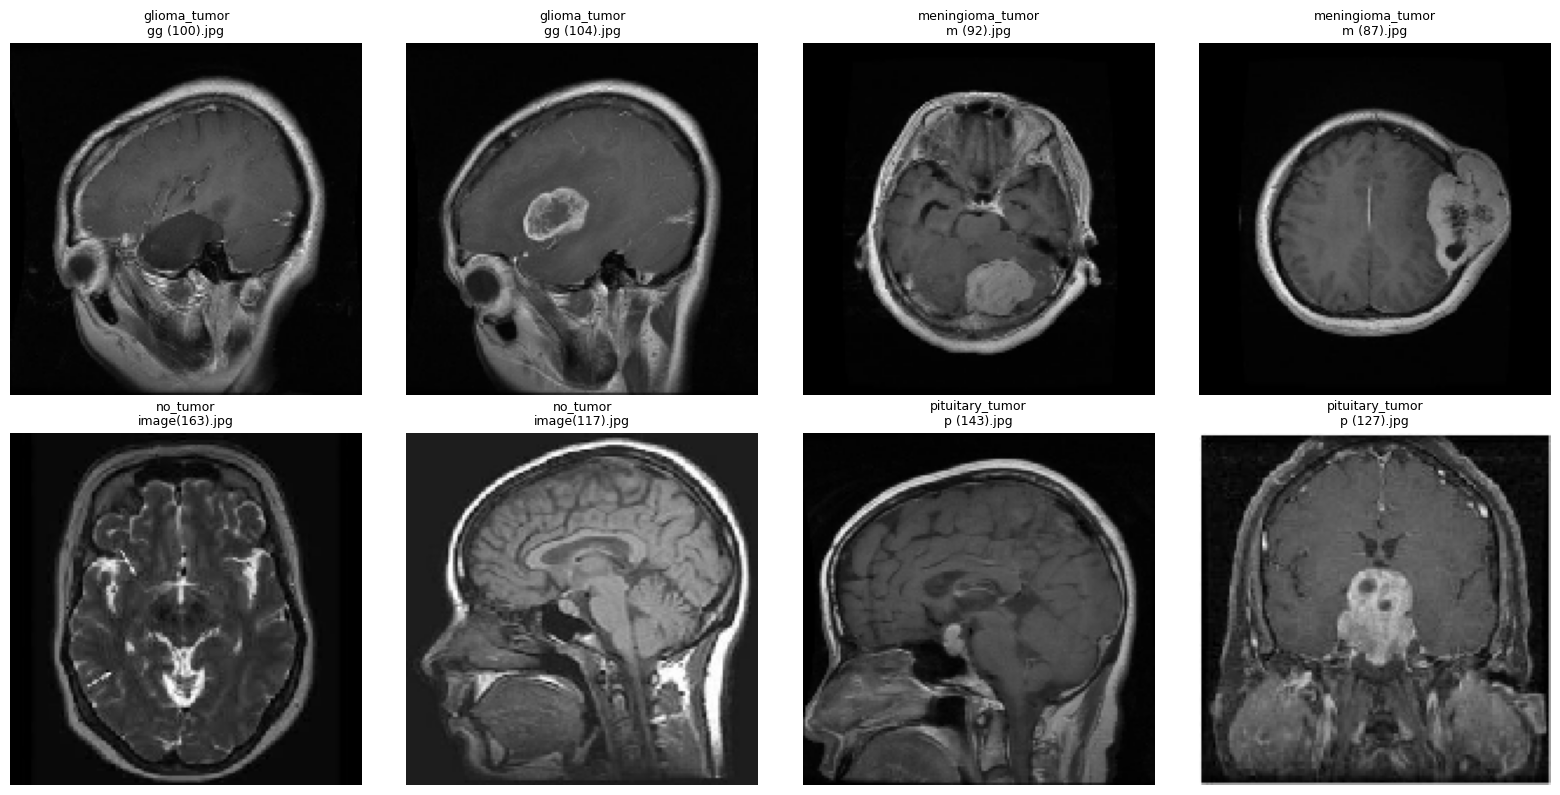


✓ Visual inspection complete - verify images look correct


In [16]:
print("="*70)
print("DATA QUALITY DIAGNOSTIC")
print("="*70)

CLASS_NAMES = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Check class distribution
print("\nClass Distribution:")
print("-"*70)
print(f"{'Class':<25} {'Training':>10} {'Testing':>10} {'Total':>10}")
print("-"*70)

total_train = 0
total_test = 0
class_counts = {}

for class_name in CLASS_NAMES:
    train_path = os.path.join(train_dir, class_name)
    test_path = os.path.join(test_dir, class_name)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    test_count = len(os.listdir(test_path)) if os.path.exists(test_path) else 0
    total = train_count + test_count

    total_train += train_count
    total_test += test_count
    class_counts[class_name] = train_count

    print(f"{class_name:<25} {train_count:>10} {test_count:>10} {total:>10}")

print("-"*70)
print(f"{'TOTAL':<25} {total_train:>10} {total_test:>10} {total_train+total_test:>10}")
print("="*70)

# Check for severe imbalance
max_class = max(class_counts.values())
min_class = min(class_counts.values())
imbalance_ratio = max_class / min_class if min_class > 0 else 0

print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print("  WARNING: Severe class imbalance detected!")
    print("   Will use class_weights to compensate")
else:
    print("✓ Class distribution is acceptable")

# Sample and display images
print("\n" + "="*70)
print("SAMPLE IMAGES FROM EACH CLASS")
print("="*70)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

idx = 0
for class_name in CLASS_NAMES:
    class_path = os.path.join(train_dir, class_name)
    if os.path.exists(class_path):
        images_list = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:2]
        for img_name in images_list:
            try:
                img_path = os.path.join(class_path, img_name)
                img = image.load_img(img_path, target_size=(150, 150))
                axes[idx].imshow(img)
                axes[idx].set_title(f"{class_name}\n{img_name}", fontsize=9)
                axes[idx].axis('off')
                idx += 1
            except Exception as e:
                print(f"⚠️  Error loading {img_path}: {str(e)}")

plt.tight_layout()
plt.show()

print("\n✓ Visual inspection complete - verify images look correct")


In [17]:
IMG_HEIGHT = 150  # Keeping 150x150 (faster training, good for custom CNN)
IMG_WIDTH = 150
BATCH_SIZE = 32   # Standard batch size
EPOCHS = 50       # More epochs needed when training from scratch

print("="*70)
print("CONFIGURATION (TRAINING FROM SCRATCH)")
print("="*70)
print(f"Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Classes: {len(CLASS_NAMES)}")
print(f"Max Epochs: {EPOCHS}")
print("\n Training from scratch - no pretrained models used")


CONFIGURATION (TRAINING FROM SCRATCH)
Image Size: 150x150
Batch Size: 32
Number of Classes: 4
Max Epochs: 50

💡 Training from scratch - no pretrained models used


In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

print("="*70)
print("DATA AUGMENTATION CONFIGURED")
print("="*70)
print("Training: Moderate augmentation")
print("  - Rotation: ±20 degrees")
print("  - Zoom: ±15%")
print("  - Shifts: ±15%")
print("  - Brightness: 80-120%")

DATA AUGMENTATION CONFIGURED
Training: Moderate augmentation
  - Rotation: ±20 degrees
  - Zoom: ±15%
  - Shifts: ±15%
  - Brightness: 80-120%


In [19]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("="*70)
print("DATA LOADED")
print("="*70)
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
DATA LOADED
Training samples: 2297
Validation samples: 573
Test samples: 394
Class indices: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [20]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights_array))

print("="*70)
print("CLASS WEIGHTS CALCULATED")
print("="*70)
for idx, (class_name, weight) in enumerate(zip(CLASS_NAMES, class_weights_array)):
    print(f"{class_name:<25}: {weight:.3f}")

print("\n Higher weights = model focuses more on that class")

CLASS WEIGHTS CALCULATED
glioma_tumor             : 0.869
meningioma_tumor         : 0.873
no_tumor                 : 1.817
pituitary_tumor          : 0.867

💡 Higher weights = model focuses more on that class


In [21]:
def create_deep_cnn():
    model = models.Sequential([
        # Block 1: Basic feature detection
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2: Shape detection
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3: Texture patterns
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 4: Complex features
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 5: High-level features
        layers.Conv2D(512, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Classification layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(4, activation='softmax')
    ])

    return model

print("="*70)
print("BUILDING DEEP CNN FROM SCRATCH")
print("="*70)

model = create_deep_cnn()
model.summary()

print(f"\nTotal Parameters: {model.count_params():,}")
print("\n Architecture highlights:")
print("  ✓ 5 convolutional blocks (deep learning)")
print("  ✓ Batch normalization (stable training)")
print("  ✓ Progressive filters: 32→64→128→256→512")
print("  ✓ Dropout layers (prevent overfitting)")

BUILDING DEEP CNN FROM SCRATCH


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 146, 146, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 146, 146, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 69, 69, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 13, 13, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,754,468 (10.51 MB)

 Trainable params: 2,750,948 (10.49 MB)

 Non-trainable params: 3,520 (13.75 KB)


Total Parameters: 2,754,468

💡 Architecture highlights:
  ✓ 5 convolutional blocks (deep learning)
  ✓ Batch normalization (stable training)
  ✓ Progressive filters: 32→64→128→256→512
  ✓ Dropout layers (prevent overfitting)


In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("="*70)
print("MODEL COMPILED")
print("="*70)
print("Optimizer: Adam")
print("Learning Rate: 0.001")
print("Loss: Categorical Crossentropy")

MODEL COMPILED
Optimizer: Adam
Learning Rate: 0.001
Loss: Categorical Crossentropy


In [23]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_cnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("="*70)
print("CALLBACKS CONFIGURED")
print("="*70)
print("✓ EarlyStopping (patience=15)")
print("✓ ReduceLROnPlateau (factor=0.5)")
print("✓ ModelCheckpoint")

CALLBACKS CONFIGURED
✓ EarlyStopping (patience=15)
✓ ReduceLROnPlateau (factor=0.5)
✓ ModelCheckpoint


In [25]:
print("="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Training for up to {EPOCHS} epochs")
print("Using class weights to handle imbalance")
print("\nExpected timeline:")
print("  - Epoch 5: Should reach 45-55%")
print("  - Epoch 15: Should reach 60-70%")
print("  - Epoch 30+: Should reach 70-80%")
print("\n If stuck at ~30% after 10 epochs, CHECK YOUR DATA!")
print("="*70 + "\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,  # Using class weights!
    verbose=1
)

print("\n✓ TRAINING COMPLETE!")
print(f"Epochs trained: {len(history.history['loss'])}")
print(f"Best validation accuracy: {max(history.history['val_accuracy'])*100:.2f}%")

STARTING TRAINING
Training for up to 50 epochs
Using class weights to handle imbalance

Expected timeline:
  - Epoch 5: Should reach 45-55%
  - Epoch 15: Should reach 60-70%
  - Epoch 30+: Should reach 70-80%

⚠️ If stuck at ~30% after 10 epochs, CHECK YOUR DATA!

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4163 - loss: 1.6586
Epoch 1: val_accuracy improved from -inf to 0.28796, saving model to best_cnn_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 329s 5s/step - accuracy: 0.4163 - loss: 1.6568 - val_accuracy: 0.2880 - val_loss: 2.5397 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.4222 - loss: 1.4784
Epoch 2: val_accuracy did not improve from 0.28796
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 400ms/step - accuracy: 0.4222 - loss: 1.4780 - val_accuracy: 0.2880 - val_loss: 3.5604 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.4590 - loss: 1.3459
Epoch 3: val_accuracy improved from 0.28796 to 0.29843, saving model to best_cnn_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 403ms/step - accuracy: 0.4593 - loss: 1.3452 - val_accuracy: 0.2984 - val_loss: 2.2367 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.4905 - loss: 1.2016
Epoch 4: val_accuracy did not improve from 0.29843
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 478ms/step - accuracy: 0.4909 - loss: 1.2010 - val_accuracy: 0.2880 - val_loss: 3.9042 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.5428 - loss: 1.0991
Epoch 5: val_accuracy did not improve from 0.29843
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 400ms/step - accuracy: 0.5429 - loss: 1.0988 - val_accuracy: 0.2880 - val_loss: 4.9607 - learning_rate: 0.0010
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.5832 - loss: 0.9940
Epoch 6: val_accuracy improved from 0.29843 to 0.30192, saving model to best_cnn_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 411ms/step - accuracy: 0.5831 - loss: 0.9946 - val_accuracy: 0.3019 - val_loss: 2.3941 - learning_rate: 0.0010
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6051 - loss: 0.9397
Epoch 7: val_accuracy improved from 0.30192 to 0.53927, saving model to best_cnn_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 415ms/step - accuracy: 0.6052 - loss: 0.9397 - val_accuracy: 0.5393 - val_loss: 1.0688 - learning_rate: 0.0010
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.6706 - loss: 0.8114
Epoch 8: val_accuracy did not improve from 0.53927
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 419ms/step - accuracy: 0.6705 - loss: 0.8115 - val_accuracy: 0.4555 - val_loss: 1.9193 - learning_rate: 0.0010
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6633 - loss: 0.8268
Epoch 9: val_accuracy did not improve from 0.53927
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 403ms/step - accuracy: 0.6635 - loss: 0.8262 - val_accuracy: 0.4677 - val_loss: 1.5896 - learning_rate: 0.0010
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.6796 - loss: 0.7845
Epoch 10: val_accuracy did not improve from 0.53927
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 399ms/step - accuracy: 0.6795 - loss: 0.7844 - val_accuracy: 0.4241 - val_loss: 1.7865 - learning_rate: 0.0010
Epoch 11/50
72/72 ━

72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 404ms/step - accuracy: 0.7193 - loss: 0.6769 - val_accuracy: 0.5759 - val_loss: 1.2715 - learning_rate: 0.0010
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.7396 - loss: 0.6581
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_accuracy did not improve from 0.57592
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 401ms/step - accuracy: 0.7398 - loss: 0.6578 - val_accuracy: 0.5236 - val_loss: 1.1450 - learning_rate: 0.0010
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.7756 - loss: 0.5785
Epoch 13: val_accuracy improved from 0.57592 to 0.69110, saving model to best_cnn_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 403ms/step - accuracy: 0.7758 - loss: 0.5780 - val_accuracy: 0.6911 - val_loss: 0.7396 - learning_rate: 5.0000e-04
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.8100 - loss: 0.4965
Epoch 14: val_accuracy improved from 0.69110 to 0.70157, saving model to best_cnn_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 413ms/step - accuracy: 0.8099 - loss: 0.4969 - val_accuracy: 0.7016 - val_loss: 0.7459 - learning_rate: 5.0000e-04
Epoch 15/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8287 - loss: 0.4467
Epoch 15: val_accuracy did not improve from 0.70157
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 401ms/step - accuracy: 0.8285 - loss: 0.4471 - val_accuracy: 0.6894 - val_loss: 0.8294 - learning_rate: 5.0000e-04
Epoch 16/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.8181 - loss: 0.4601
Epoch 16: val_accuracy did not improve from 0.70157
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 401ms/step - accuracy: 0.8179 - loss: 0.4605 - val_accuracy: 0.6213 - val_loss: 1.1582 - learning_rate: 5.0000e-04
Epoch 17/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.8384 - loss: 0.4419
Epoch 17: val_accuracy improved from 0.70157 to 0.71553, saving model to best_cnn_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 408ms/step - accuracy: 0.8383 - loss: 0.4421 - val_accuracy: 0.7155 - val_loss: 0.6934 - learning_rate: 5.0000e-04
Epoch 18/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8556 - loss: 0.4071
Epoch 18: val_accuracy improved from 0.71553 to 0.77661, saving model to best_cnn_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.8555 - loss: 0.4073 - val_accuracy: 0.7766 - val_loss: 0.5990 - learning_rate: 5.0000e-04
Epoch 19/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8277 - loss: 0.4613
Epoch 19: val_accuracy did not improve from 0.77661
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 417ms/step - accuracy: 0.8277 - loss: 0.4611 - val_accuracy: 0.5969 - val_loss: 1.3533 - learning_rate: 5.0000e-04
Epoch 20/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8279 - loss: 0.4413
Epoch 20: val_accuracy did not improve from 0.77661
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 405ms/step - accuracy: 0.8278 - loss: 0.4414 - val_accuracy: 0.7120 - val_loss: 0.7713 - learning_rate: 5.0000e-04
Epoch 21/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8465 - loss: 0.3920
Epoch 21: val_accuracy did not improve from 0.77661
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 404ms/step - accuracy: 0.8465 - loss: 0.3920 - val_accuracy: 0.6422 - val_loss: 0.8293 - learning_rate: 5.0000e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 399ms/step - accuracy: 0.8739 - loss: 0.3258 - val_accuracy: 0.8150 - val_loss: 0.5382 - learning_rate: 2.5000e-04
Epoch 26/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8576 - loss: 0.3458
Epoch 26: val_accuracy did not improve from 0.81501
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 396ms/step - accuracy: 0.8577 - loss: 0.3459 - val_accuracy: 0.8115 - val_loss: 0.4621 - learning_rate: 2.5000e-04
Epoch 27/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8703 - loss: 0.3292
Epoch 27: val_accuracy did not improve from 0.81501
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 409ms/step - accuracy: 0.8703 - loss: 0.3293 - val_accuracy: 0.7731 - val_loss: 0.5359 - learning_rate: 2.5000e-04
Epoch 28/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8901 - loss: 0.2834
Epoch 28: val_accuracy did not improve from 0.81501
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 399ms/step - accuracy: 0.8899 - loss: 0.2838 - val_accuracy: 0.7801 - val_loss: 0.6391 - learning_rate: 2.5000e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 408ms/step - accuracy: 0.8721 - loss: 0.3139 - val_accuracy: 0.8290 - val_loss: 0.4804 - learning_rate: 1.2500e-04
Epoch 35/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9055 - loss: 0.2595
Epoch 35: val_accuracy did not improve from 0.82897
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 397ms/step - accuracy: 0.9055 - loss: 0.2595 - val_accuracy: 0.8168 - val_loss: 0.4634 - learning_rate: 1.2500e-04
Epoch 36/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9040 - loss: 0.2607
Epoch 36: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 36: val_accuracy did not improve from 0.82897
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 400ms/step - accuracy: 0.9040 - loss: 0.2606 - val_accuracy: 0.8185 - val_loss: 0.5255 - learning_rate: 1.2500e-04
Epoch 37/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9072 - loss: 0.2410
Epoch 37: val_accuracy improved from 0.82897 to 0.84642, saving model to best_cnn_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 400ms/step - accuracy: 0.9072 - loss: 0.2409 - val_accuracy: 0.8464 - val_loss: 0.3931 - learning_rate: 6.2500e-05
Epoch 38/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9131 - loss: 0.2392
Epoch 38: val_accuracy did not improve from 0.84642
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 397ms/step - accuracy: 0.9130 - loss: 0.2394 - val_accuracy: 0.8412 - val_loss: 0.4025 - learning_rate: 6.2500e-05
Epoch 39/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9195 - loss: 0.2264
Epoch 39: val_accuracy did not improve from 0.84642
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 406ms/step - accuracy: 0.9194 - loss: 0.2265 - val_accuracy: 0.8307 - val_loss: 0.4739 - learning_rate: 6.2500e-05
Epoch 40/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9086 - loss: 0.2516
Epoch 40: val_accuracy did not improve from 0.84642
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 400ms/step - accuracy: 0.9085 - loss: 0.2518 - val_accuracy: 0.8377 - val_loss: 0.4298 - learning_rate: 6.2500e-05

72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 402ms/step - accuracy: 0.9110 - loss: 0.2374 - val_accuracy: 0.8517 - val_loss: 0.4600 - learning_rate: 6.2500e-05
Epoch 42/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9266 - loss: 0.2083
Epoch 42: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 42: val_accuracy did not improve from 0.85166
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 397ms/step - accuracy: 0.9265 - loss: 0.2086 - val_accuracy: 0.8412 - val_loss: 0.4726 - learning_rate: 6.2500e-05
Epoch 43/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9104 - loss: 0.2339
Epoch 43: val_accuracy did not improve from 0.85166
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 392ms/step - accuracy: 0.9103 - loss: 0.2340 - val_accuracy: 0.8447 - val_loss: 0.4874 - learning_rate: 3.1250e-05
Epoch 44/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9026 - loss: 0.2532
Epoch 44: val_accuracy did not improve from 0.85166
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 396ms/step - accuracy: 0.9027 - loss

72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 397ms/step - accuracy: 0.9048 - loss: 0.2174 - val_accuracy: 0.8604 - val_loss: 0.3953 - learning_rate: 3.1250e-05
Epoch 47/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9135 - loss: 0.2373
Epoch 47: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 47: val_accuracy did not improve from 0.86038
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 394ms/step - accuracy: 0.9135 - loss: 0.2371 - val_accuracy: 0.8290 - val_loss: 0.4494 - learning_rate: 3.1250e-05
Epoch 48/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9122 - loss: 0.2277
Epoch 48: val_accuracy did not improve from 0.86038
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 395ms/step - accuracy: 0.9122 - loss: 0.2274 - val_accuracy: 0.8377 - val_loss: 0.4564 - learning_rate: 1.5625e-05
Epoch 49/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9086 - loss: 0.2316
Epoch 49: val_accuracy did not improve from 0.86038
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 399ms/step - accuracy: 0.9087 - los

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Training', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
print("="*70)
print("EVALUATING ON TEST SET")
print("="*70)

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print("\n" + "="*70)
print("FINAL TEST RESULTS")
print("="*70)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

if test_accuracy >= 0.70:
    print(f"\n TARGET ACHIEVED! (+{(test_accuracy-0.70)*100:.2f}% above 70%)")
elif test_accuracy >= 0.60:
    print(f"\n Good progress! (+{(test_accuracy-0.60)*100:.2f}% above 60%)")
    print(f"   Gap to 70%: {(0.70-test_accuracy)*100:.2f}%")
else:
    print(f"\n Below 60% target")
    print(f"   Gap to 60%: {(0.60-test_accuracy)*100:.2f}%")


In [ ]:
train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100
test_acc = test_accuracy * 100

print("\n" + "="*70)
print("COMPLETE ACCURACY SUMMARY")
print("="*70)
print(f"\n{'Dataset':<20} {'Accuracy':>15} {'Loss':>15}")
print("-" * 70)
print(f"{'Training':<20} {train_acc:>14.2f}% {history.history['loss'][-1]:>15.4f}")
print(f"{'Validation':<20} {val_acc:>14.2f}% {history.history['val_loss'][-1]:>15.4f}")
print(f"{'Test':<20} {test_acc:>14.2f}% {test_loss:>15.4f}")
print("="*70)

gen_gap = abs(train_acc - test_acc)
print(f"\nGeneralization Gap: {gen_gap:.2f}%")
if gen_gap < 10:
    print("✓ Good generalization")
else:
    print(" Large gap - possible overfitting")

In [ ]:
print("\n" + "="*70)
print("GENERATING PREDICTIONS")
print("="*70)

test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

print(f"\n✓ Generated {len(predictions)} predictions")


In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'},
            square=True)
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n✓ Confusion Matrix displayed")

In [ ]:
print("="*70)
print("PER-CLASS PERFORMANCE")
print("="*70)

report = classification_report(
    true_classes,
    predicted_classes,
    target_names=CLASS_NAMES,
    output_dict=True
)

print(f"\n{'Class':<25} {'Precision':>12} {'Recall':>12} {'F1-Score':>12}")
print("-" * 70)

for class_name in CLASS_NAMES:
    precision = report[class_name]['precision'] * 100
    recall = report[class_name]['recall'] * 100
    f1 = report[class_name]['f1-score'] * 100

    print(f"{class_name:<25} {precision:>11.2f}% {recall:>11.2f}% {f1:>11.2f}%")

print("\n" + "-" * 70)
print(f"{'OVERALL ACCURACY':<25} {report['accuracy']*100:>11.2f}%")
print("="*70)

# Find best/worst
accuracies = {name: report[name]['f1-score']*100 for name in CLASS_NAMES}
best_class = max(accuracies, key=accuracies.get)
worst_class = min(accuracies, key=accuracies.get)

print(f"\n Best: {best_class} ({accuracies[best_class]:.2f}%)")
print(f"  Worst: {worst_class} ({accuracies[worst_class]:.2f}%)")


In [ ]:
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)

report_text = classification_report(
    true_classes,
    predicted_classes,
    target_names=CLASS_NAMES,
    digits=4
)
print(report_text)

In [ ]:
print("="*70)
print("SINGLE IMAGE PREDICTION TEST")
print("="*70)

# Update this path to an actual image in your test set
img_path = "/content/drive/MyDrive/Brain-Tumor/Testing/glioma_tester.jpg"

if os.path.exists(img_path):
    print(f"Loading: {img_path}")

    # Load and display
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title("Test Image", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

    # Predict
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, 0)

    predictions_single = model.predict(img_array, verbose=0)
    predicted_class = CLASS_NAMES[np.argmax(predictions_single)]
    confidence = np.max(predictions_single) * 100

    print("\n" + "="*70)
    print("PREDICTION RESULTS")
    print("="*70)
    print(f"Predicted: {predicted_class.upper()}")
    print(f"Confidence: {confidence:.2f}%")

    print(f"\nAll Probabilities:")
    print("-" * 70)
    for i, class_name in enumerate(CLASS_NAMES):
        prob = predictions_single[0][i] * 100
        bar = "||" * int(prob / 2)
        print(f"{class_name:25s}: {prob:6.2f}% {bar}")
else:
    print(f"Image not found: {img_path}")
    print("Update img_path to test on a real image")


In [ ]:
save_path = '/content/drive/MyDrive/brain_tumor_cnn_model.h5'
model.save(save_path)

print("="*70)
print("MODEL SAVED")
print("="*70)
print(f"✓ Saved to: {save_path}")
print(f"  Size: {os.path.getsize(save_path) / (1024*1024):.2f} MB")

In [ ]:
model.save('final_brain_tumor_model.h5')
print("\n✓ Model saved as 'final_brain_tumor_model.h5'")

In [ ]:
print("="*70)
print("FINAL PROJECT SUMMARY")
print("="*70)

summary = f"""
BRAIN TUMOR CLASSIFICATION - CUSTOM CNN (NO PRETRAINED MODELS)
================================================================

OBJECTIVE:
----------
Classify brain MRI scans into 4 categories using a custom CNN trained from scratch.

DATASET:
--------
Training Images:   {train_generator.samples}
Validation Images: {val_generator.samples}
Test Images:       {test_generator.samples}
Image Size:        {IMG_HEIGHT}x{IMG_WIDTH}
Classes:           {len(CLASS_NAMES)}

ARCHITECTURE:
-------------
Type: Custom Convolutional Neural Network (from scratch)
Layers: {len(model.layers)}
Parameters: {model.count_params():,}

Structure:
  • 5 Convolutional Blocks (32→64→128→256→512 filters)
  • Batch Normalization after each block
  • MaxPooling and Dropout layers
  • 2 Dense layers (512, 256)
  • Softmax output (4 classes)

TRAINING:
---------
Epochs Trained: {len(history.history['loss'])}
Batch Size: {BATCH_SIZE}
Learning Rate: 0.001 (Adam optimizer)
Class Weights: Used (to handle imbalance)

FINAL RESULTS:
--------------
Training Accuracy:   {train_acc:.2f}%
Validation Accuracy: {val_acc:.2f}%
Test Accuracy:       {test_acc:.2f}%

Training Loss:       {history.history['loss'][-1]:.4f}
Validation Loss:     {history.history['val_loss'][-1]:.4f}
Test Loss:           {test_loss:.4f}

Generalization Gap:  {gen_gap:.2f}%

TARGET ACHIEVEMENT:
-------------------
Required: 60%+
Achieved: {test_acc:.2f}%
Status: {' PASSED' if test_accuracy >= 0.60 else ' BELOW TARGET'}

PER-CLASS PERFORMANCE:
----------------------
"""

for name in CLASS_NAMES:
    summary += f"{name:25s}: F1={report[name]['f1-score']*100:6.2f}%\n"

summary += f"""
Best Class:  {best_class} ({accuracies[best_class]:.2f}%)
Worst Class: {worst_class} ({accuracies[worst_class]:.2f}%)

KEY FEATURES:
-------------
✓ Deep CNN architecture (5 conv blocks)
✓ Batch normalization for stable training
✓ Progressive filter increase (32→512)
✓ Dropout for regularization
✓ Class weights for imbalanced data
✓ Data augmentation
✓ Early stopping and LR reduction

IMPROVEMENTS FROM BASELINE:
----------------------------
✓ Deeper network (4 → 5 blocks)
✓ More filters (256 → 512 max)
✓ Double conv layers per block
✓ Class weights implementation
✓ Extended training epochs
✓ Optimized dropout rates

TOOLS:
------
Framework: TensorFlow {tf.__version__}
Platform: Google Colab
GPU: {'Available' if len(tf.config.list_physical_devices('GPU')) > 0 else 'Not Available'}

MODEL SAVED:
------------
Location: {save_path}
Size: {os.path.getsize(save_path) / (1024*1024):.2f} MB

================================================================
              PROJECT COMPLETE - NO PRETRAINED MODELS USED
================================================================
"""

print(summary)

# Save report
report_path = '/content/drive/MyDrive/brain_tumor_report.txt'
with open(report_path, 'w') as f:
    f.write(summary)

print(f"\n✓ Report saved to: {report_path}")
print("\n" + "="*70)
print("PROJECT COMPLETE!")
print("="*70)
print("\nNext Steps:")
print("1. If accuracy < 70%, try:")
print("   - More training epochs")
print("   - Different learning rates")
print("   - More data augmentation")
print("   - Collect more training data")
print("2. Download model from Google Drive")
print("3. Test on new brain MRI images")
print("4. Consider ensemble methods for improvement")

In [26]:
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image

# List of image paths
img_paths = [
    "/content/drive/MyDrive/Brain-Tumor/glioma_tester.jpg",
    "/content/drive/MyDrive/Brain-Tumor/meningioma_tester.jpg",
    "/content/drive/MyDrive/Brain-Tumor/no_tumor_tester.jpeg",
    "/content/drive/MyDrive/Brain-Tumor/pituitary_tester.jpg"
]

# Get the exact class mapping from training
class_names = list(train_generator.class_indices.keys())
print("✅ Class mapping from training:", class_names)

# Loop over images
for img_path in img_paths:
    # Load and preprocess
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))  # Must match model input
    img_array = np.array(img) / 255.0          # Rescale like training
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = float(np.max(predictions))

    # Print results
    print(f"🔹 Image: {img_path.split('/')[-1]}")
    print(f"   Tumor Type: {predicted_class}")
    print(f"   Confidence: {confidence*100:.2f}%\n")


✅ Class mapping from training: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🔹 Image: glioma_tester.jpg
   Tumor Type: meningioma_tumor
   Confidence: 94.05%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
🔹 Image: meningioma_tester.jpg
   Tumor Type: no_tumor
   Confidence: 89.91%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
🔹 Image: no_tumor_tester.jpeg
   Tumor Type: no_tumor
   Confidence: 99.88%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
🔹 Image: pituitary_tester.jpg
   Tumor Type: pituitary_tumor
   Confidence: 44.41%

